This Jupyter notebook contains everything needed for the LED board calibration. It is based on Emma's previous notebook.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import scipy.constants as const
from scipy import integrate

In [ ]:
c = const.c 
h = const.h

print("c =", c, "m/s"
      "h =", h, "J*s")

#This is to convert between  power (W) and photon flux (photons/s)
photonsPerSecond = lambda power, wavelength: power*wavelength/(h*c)

# W = 2.8e-3 #watts
# wavelength = 255e-9 #m
# Nphotons = photonsPerSecond(W, wavelength)

c = 299792458.0 m/sh = 6.62607015e-34 J*s


In [ ]:
"""
If you want to rerun this code, make sure to change the file path, as the format of the current file has been modified.
It now includes an additional column called photonsPerSecond (#photons/s).
To run the notebook, use the raw files such as LED_calibration_LED_A_20nsRAW.csv or LED_calibration_LED_A_200nsRAW.csv, which are in the correct format.
The file diode measurements (Raw) contains the data exactly as I recorded it, without any formatting.
"""

file = "LED_calibration_LED_A_20ns.csv"
dataTake = pd.read_csv(file,header=0)


df_20ns = pd.read_csv("LED_calibration_LED_A_20ns.csv", delimiter=";") 
print(df_20ns.head())   
voltage_20ns = df_20ns["Voltage(V)"]

#Dark current subtraction
current_20ns = df_20ns["Current (pA)"] - 0.06

   Voltage(V)  Current (pA)
0          32          10.0
1          31           9.6
2          30           9.2
3          29           8.9
4          28           8.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


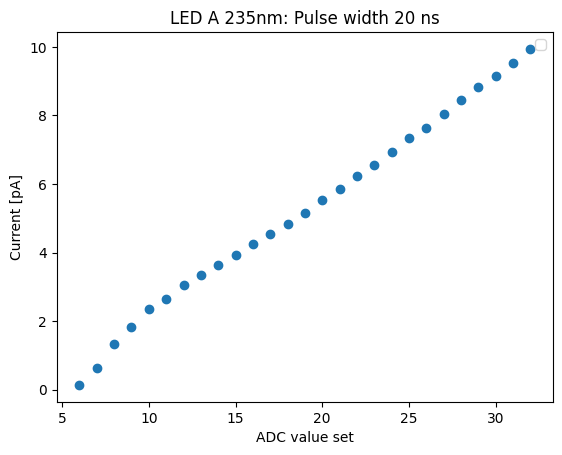

In [4]:
plt.scatter(voltage_20ns, current_20ns)
plt.xlabel("ADC value set")
plt.ylabel("Current [pA]")
plt.title(f"LED A 235nm: Pulse width 20 ns")
plt.show()

Photodiode calibration


In [3]:
fileN = "NIST_calibration_AXUV100G_1140340055.csv"
NISTcal = pd.read_csv(fileN, comment='#')

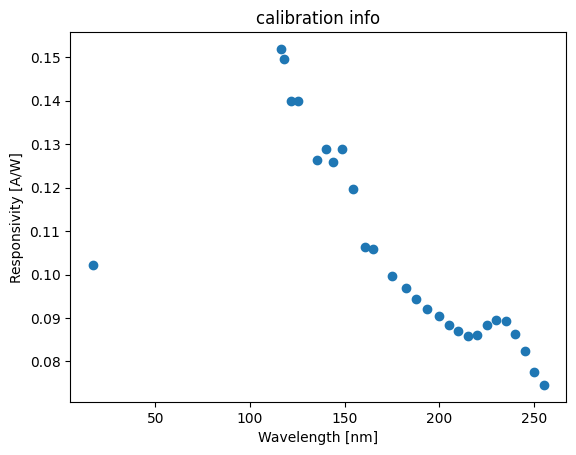

In [4]:
NISTcal.keys()

plt.scatter(NISTcal["Wavelength [nm]"], NISTcal["Responsivity [A/W]"])
plt.xlabel("Wavelength [nm]")
plt.ylabel("Responsivity [A/W]")
plt.title(f"calibration info")
plt.show()

In [5]:
singleResponse = NISTcal[NISTcal["Wavelength [nm]"] == 235]
singleResponse['Responsivity [A/W]'].item()

0.0893

In [ ]:
#I change this from previous version of the code becasuse it was missing the 1/singleResponse factor to account for the correct unit conversion
simpleopticalPower_20ns=current_20ns.apply(lambda x: x/singleResponse['Responsivity [A/W]'].item())


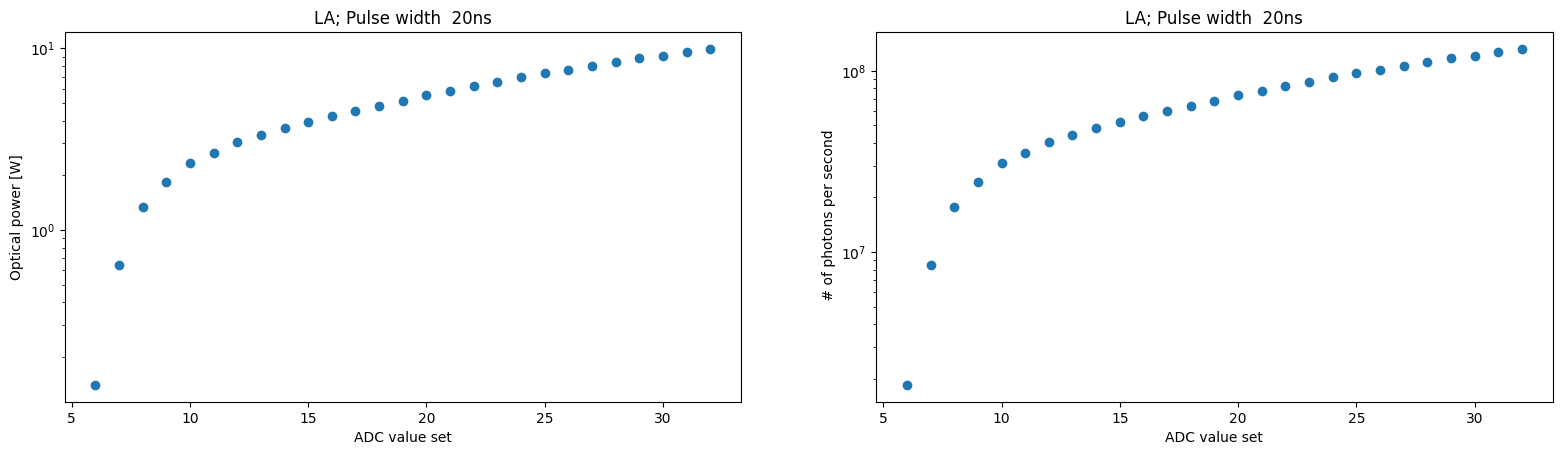

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19.2, 4.8))  
ax1.scatter(voltage_20ns, current_20ns)
ax1.set_xlabel("ADC value set")
ax1.set_ylabel("Optical power [W]")

photons =  photonsPerSecond(235*1e-9, simpleopticalPower_20ns*1e-12)  # Convert pA to A and nm to m
#TODO
#Here is where the new column is added 
df_20ns["photonsPerSecond (#photons/s)"]=photons
#Change the name of the file as needed
df_20ns.to_csv("LED_calibration_LED_A_20ns.csv")

ax2.scatter(voltage_20ns, photons)
ax2.set_ylabel(" # of photons per second")
ax2.set_xlabel("ADC value set")

#Log scale to better visualize the data, feel free to change it

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_title(f"LA; Pulse width  20ns")
ax2.set_title(f"LA; Pulse width  20ns")

xmin=ax2.get_xlim()[0]
xmax=ax2.get_xlim()[1]

plt.show();

In [11]:
df_20ns = pd.read_csv("LED_calibration_LED_A_20ns.csv", delimiter=",") 

print(df_20ns.head())   

voltage_20ns = df_20ns["Voltage(V)"]
current_20ns = df_20ns["Current (pA)"] 
photonsPerSecond_20ns = df_20ns["photonsPerSecond (#photons/s)"] 



   Unnamed: 0  Voltage(V)  Current (pA)  photonsPerSecond (#photons/s)
0           0          32          10.0                   1.316819e+08
1           1          31           9.6                   1.263828e+08
2           2          30           9.2                   1.210838e+08
3           3          29           8.9                   1.171094e+08
4           4          28           8.5                   1.118104e+08


The following two plots show the same data; one is in linear scale and the other in logarithmic scale to better visualize the shape.

slope m      = 4.695e+06
intercept b  = -1.969e+07
R²           = 0.9963


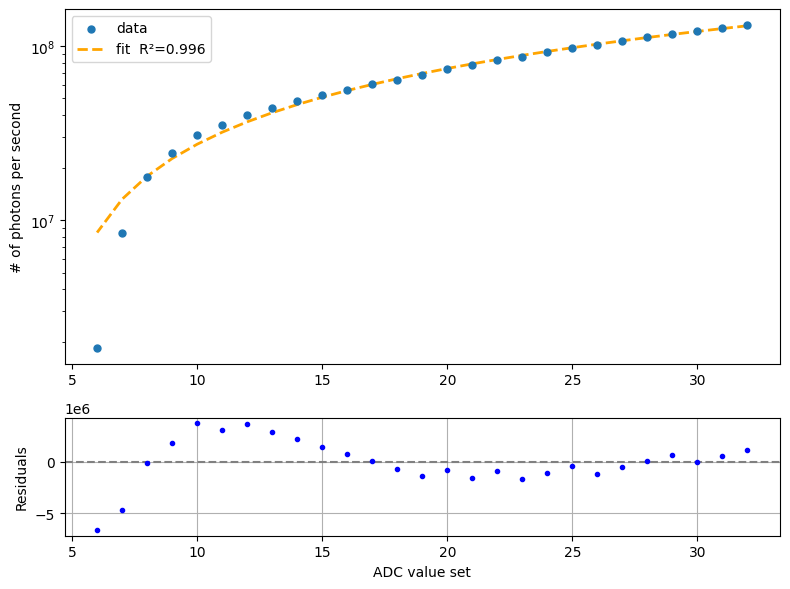

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
from matplotlib.gridspec import GridSpec

x=voltage_20ns
y=photonsPerSecond_20ns

# Linear regression

slope, intercept, r_value, p_value, std_err = linregress(x, y)
r2 = r_value**2


print(f"slope m      = {slope:.4g}")
print(f"intercept b  = {intercept:.4g}")
print(f"R²           = {r2:.4f}")


y_fit = slope * x + intercept

residuals = y - y_fit

fig = plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=[3, 1])
ax0 = plt.subplot(gs[0])

ax0.scatter(x, y, label="data", s=25, zorder=3)
ax0.plot(x, y_fit, label=f"fit  R²={r2:.3f}", linewidth=2, linestyle="--",color='orange')
ax0.set_yscale('log')
ax0.set_ylabel("# of photons per second")
ax0.legend()

ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.errorbar(x, residuals, fmt='o', markersize=3, color='blue', capsize=2)
ax1.axhline(0, color='gray', linestyle='--')
ax1.set_xlabel("ADC value set")
ax1.set_ylabel("Residuals")
ax1.grid(True)
plt.tight_layout()

plt.show();








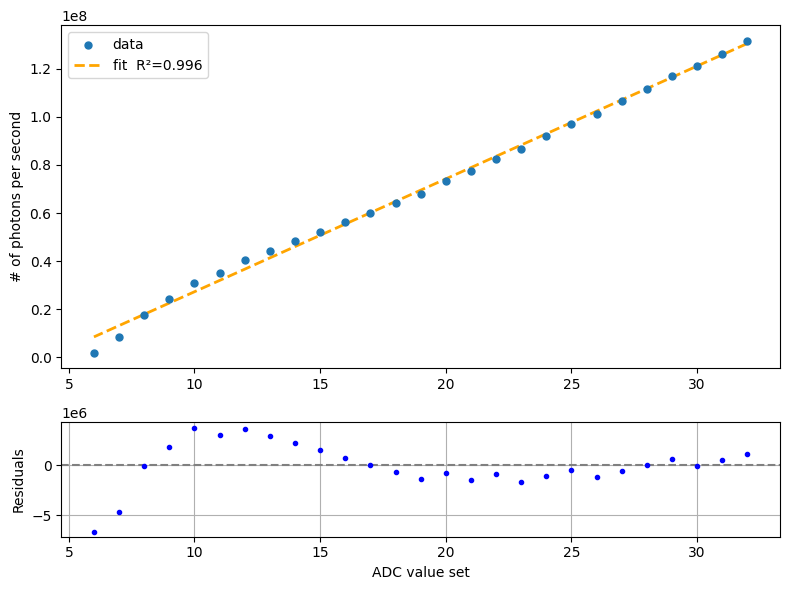

In [13]:
fig = plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=[3, 1])
ax0 = plt.subplot(gs[0])

ax0.scatter(x, y, label="data", s=25, zorder=3)
ax0.plot(x, y_fit, label=f"fit  R²={r2:.3f}", linewidth=2, linestyle="--",color='orange')
ax0.set_ylabel("# of photons per second")
ax0.legend()

ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.errorbar(x, residuals, fmt='o', markersize=3, color='blue', capsize=2)
ax1.axhline(0, color='gray', linestyle='--')
ax1.set_xlabel("ADC value set")
ax1.set_ylabel("Residuals")
ax1.grid(True)
plt.tight_layout()

plt.show();


From here on, it's the exact same procedure as above, but using the 200 ns pulse data.

In [6]:
file = "LED_calibration_LED_A_200ns.csv"
dataTake = pd.read_csv(file,header=0)


df_200ns = pd.read_csv("LED_calibration_LED_A_200ns.csv", delimiter=";") 
print(df_200ns.head())   
voltage_200ns = df_200ns["Voltage(V)"]
current_200ns = df_200ns["Current (pA)"] - 0.06

   Voltage(V)  Current (pA)
0          32          83.5
1          31          80.4
2          30          77.2
3          29          74.0
4          28          70.8


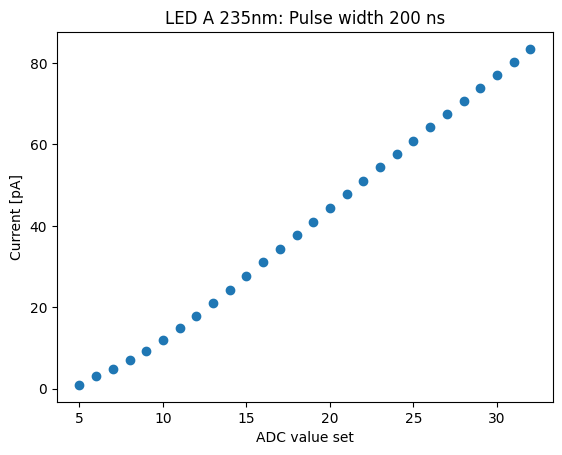

In [7]:
plt.scatter(voltage_200ns, current_200ns)
plt.xlabel("ADC value set")
plt.ylabel("Current [pA]")
plt.title(f"LED A 235nm: Pulse width 200 ns")
plt.show()

In [8]:
simpleopticalPower_200ns=current_200ns.apply(lambda x: x/singleResponse['Responsivity [A/W]'].item())

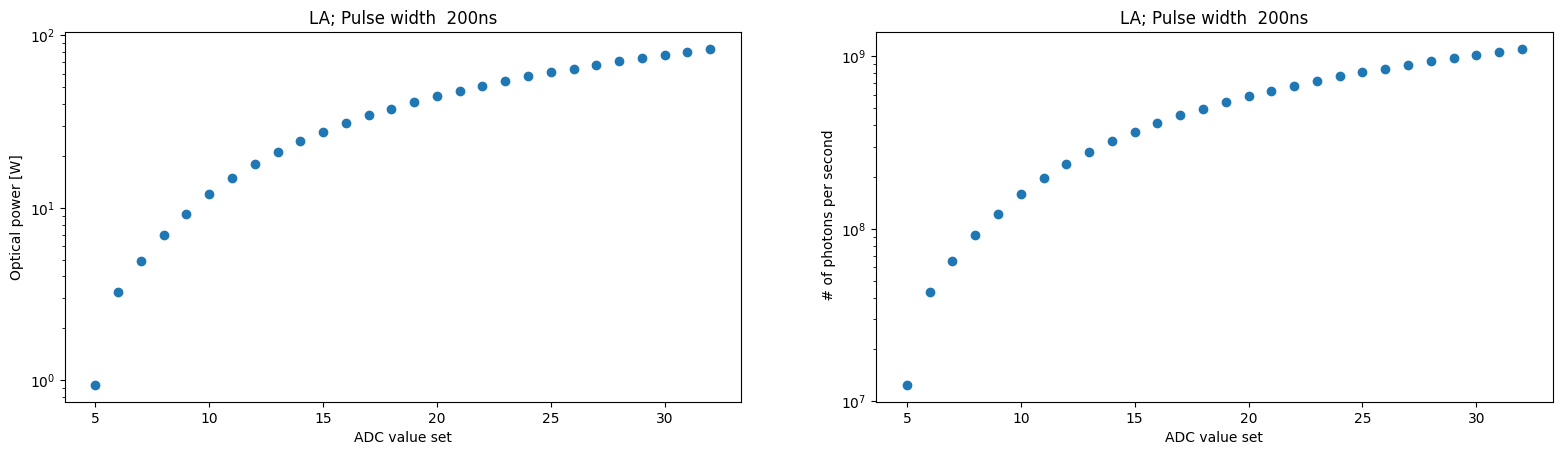

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19.2, 4.8))  
ax1.scatter(voltage_200ns, current_200ns)
ax1.set_xlabel("ADC value set")
ax1.set_ylabel("Optical power [W]")

photons =  photonsPerSecond(235*1e-9, simpleopticalPower_200ns*1e-12)  # Convert pA to A and then to 
df_200ns["photonsPerSecond (#photons/s)"]=photons
df_200ns.to_csv("LED_calibration_LED_A_200ns.csv")

ax2.scatter(voltage_200ns, photons)
ax2.set_ylabel(" # of photons per second")
ax2.set_xlabel("ADC value set")

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_title(f"LA; Pulse width  200ns")
ax2.set_title(f"LA; Pulse width  200ns")

xmin=ax2.get_xlim()[0]
xmax=ax2.get_xlim()[1]

plt.show();

In [11]:
df_200ns = pd.read_csv("LED_calibration_LED_A_200ns.csv", delimiter=",") 

print(df_200ns.head())   

voltage_200ns = df_200ns["Voltage(V)"]
current_200ns = df_200ns["Current (pA)"] 
photonsPerSecond_200ns = df_200ns["photonsPerSecond (#photons/s)"] 

   Unnamed: 0  Voltage(V)  Current (pA)  photonsPerSecond (#photons/s)
0           0          32          83.5                   1.105386e+09
1           1          31          80.4                   1.064318e+09
2           2          30          77.2                   1.021926e+09
3           3          29          74.0                   9.795331e+08
4           4          28          70.8                   9.371405e+08


slope m      = 4.201e+07
intercept b  = -2.468e+08
R²           = 0.9978


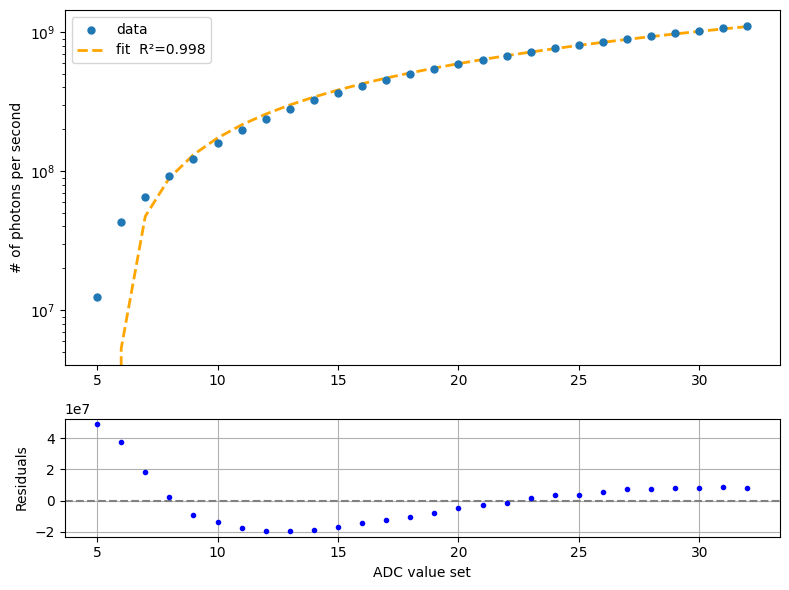

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
from matplotlib.gridspec import GridSpec

x=voltage_200ns
y=photonsPerSecond_200ns

slope, intercept, r_value, p_value, std_err = linregress(x, y)
r2 = r_value**2


print(f"slope m      = {slope:.4g}")
print(f"intercept b  = {intercept:.4g}")
print(f"R²           = {r2:.4f}")


y_fit = slope * x + intercept

residuals = y - y_fit

fig = plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=[3, 1])
ax0 = plt.subplot(gs[0])

ax0.scatter(x, y, label="data", s=25, zorder=3)
ax0.plot(x, y_fit, label=f"fit  R²={r2:.3f}", linewidth=2, linestyle="--",color='orange')
ax0.set_yscale('log')
ax0.set_ylabel("# of photons per second")
ax0.legend()

ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.errorbar(x, residuals, fmt='o', markersize=3, color='blue', capsize=2)
ax1.axhline(0, color='gray', linestyle='--')
ax1.set_xlabel("ADC value set")
ax1.set_ylabel("Residuals")
ax1.grid(True)
plt.tight_layout()

plt.show();

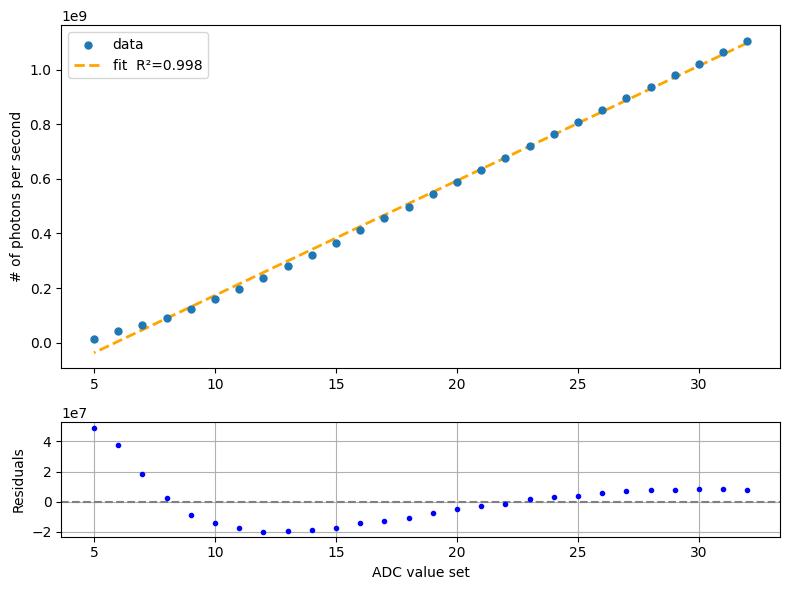

In [13]:
fig = plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=[3, 1])
ax0 = plt.subplot(gs[0])

ax0.scatter(x, y, label="data", s=25, zorder=3)
ax0.plot(x, y_fit, label=f"fit  R²={r2:.3f}", linewidth=2, linestyle="--",color='orange')
ax0.set_ylabel("# of photons per second")
ax0.legend()

ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.errorbar(x, residuals, fmt='o', markersize=3, color='blue', capsize=2)
ax1.axhline(0, color='gray', linestyle='--')
ax1.set_xlabel("ADC value set")
ax1.set_ylabel("Residuals")
ax1.grid(True)
plt.tight_layout()

plt.show();